In [1]:
%matplotlib inline

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import dump
from pickle import load

# Data Load

In [101]:
data = pd.read_csv('data/tous_exemplaires_ready.csv', sep=',', encoding="utf-8")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54463 entries, 0 to 54462
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   date_pub                   54463 non-null  int64 
 1   statut_ex                  54463 non-null  int64 
 2   bib                        54463 non-null  object
 3   pret                       54463 non-null  int64 
 4   diff_datecreation_datepub  54463 non-null  int64 
 5   acces                      54463 non-null  object
 6   acq                        54463 non-null  object
 7   indice                     54463 non-null  object
dtypes: int64(4), object(4)
memory usage: 3.3+ MB


In [105]:
cols_to_change_to_str = ["pret","statut_ex"]
for col in cols_to_change_to_str:
    data[col] = data[col].astype(str)

# Dummies variables for categorical variables

On encode les variables qualitatives ayant peu de modalités avec la méthode get_dummies de pandas :
- création d'autant de nouvelles colonnes pré-fixées avec le label de la variable que de modalités 
- suppression d'une des colonnes (param drop_first=True) pour rendre les nouvelles variables créées indépendantes

In [80]:
df = data.copy()
df = pd.get_dummies(df, columns=['bib', 'statut_ex', 'acces', 'acq'], drop_first=True, dummy_na=False)

In [81]:
cols_to_keep = [c for c in df.columns.to_list() if c != 'pret']

In [7]:
df.head()

,date_pub,pret,diff_datecreation_datepub,indice,bib_DROIT,bib_EPU,bib_LASH,bib_MEDP,bib_SCIEN,bib_SJA,bib_STAPS,statut_ex_19,acces_indirect,acq_don
0,2001,1,16,33,0,0,0,0,0,1,0,1,0,0
1,2005,1,13,868,0,0,1,0,0,0,0,1,0,1
2,2007,0,10,19,0,0,1,0,0,0,0,1,0,0
3,2007,0,13,65,0,0,0,0,0,1,0,1,0,0
4,1942,1,74,numinv,0,0,1,0,0,0,0,1,1,1


# Création du jeu d'entrainement

In [8]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df[cols_to_keep], df[["pret"]], test_size=0.2, random_state=42)

In [10]:
y_train.value_counts()

pret
0       22665
1       20905
dtype: int64

On considère que l'échantillonage réalisé a produit un dataset d'entraînement bien équilibré concernant la partition de la variable cible (pas de sur ou sous-représentation flagrande) -> on n'applique pas de technique d'over ou under sampling

## Variables quantitatives

<AxesSubplot:ylabel='Frequency'>

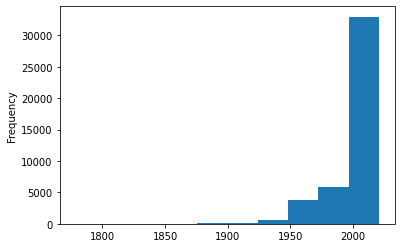

In [13]:
X_train["date_pub"].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

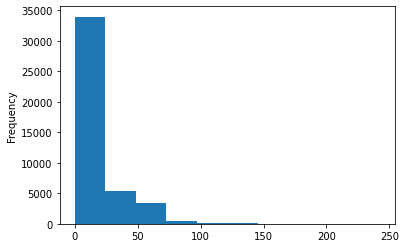

In [14]:
X_train["diff_datecreation_datepub"].plot(kind="hist")

-> Normalisation nécessaire

In [11]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

In [83]:
std_scaler = dict()
for c in ['date_pub','diff_datecreation_datepub']:
    std_scaler[f'std_scaler_{c}'] = StandardScaler()
    X_train[[f'{c}_std_scaler']] = std_scaler[f'std_scaler_{c}'].fit_transform(X_train[[c]])
    X_train.drop([c], axis = 1, inplace = True)
    X_test[[f'{c}_std_scaler']] = std_scaler[f'std_scaler_{c}'].transform(X_test[[c]])
    X_test.drop([c], axis = 1, inplace = True)

<AxesSubplot:ylabel='Frequency'>

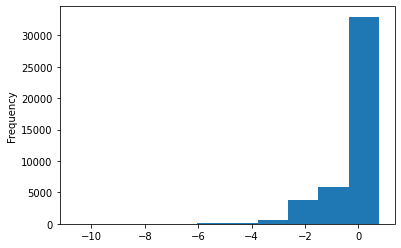

In [87]:
# -> résultat
X_train["date_pub_std_scaler"].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

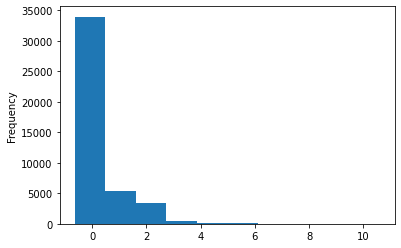

In [88]:
X_train["diff_datecreation_datepub_std_scaler"].plot(kind="hist")

In [13]:
# save the scaler
dump(std_scaler, open('transformers_models/std_scaler.pkl', 'wb'))

# Usage
# std_scaler = load(open('transformers_models/std_scaler.pkl', 'rb'))
## ex :  X_test_scaled = std_scaler.transform(X_test)
# std_scaler['std_scaler_date_pub'].transform([[2015]])

## Variable catégorielle indice

*Doc : https://datagy.io/sklearn-one-hot-encode/*

In [47]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [84]:
ohe = make_column_transformer(
    (OneHotEncoder(categories='auto', drop=None, sparse=False, handle_unknown="ignore"), ['indice']),
    remainder='passthrough')

### fit & transform sur données d'entraînement

In [85]:
transformed_train = ohe.fit_transform(X_train)
transformed_X_train = pd.DataFrame(
    transformed_train, 
    columns=transformer.get_feature_names_out()
)

In [72]:
transformed_X_train.head(2)

,onehotencoder__indice_00,onehotencoder__indice_02,onehotencoder__indice_03,onehotencoder__indice_04,onehotencoder__indice_05,onehotencoder__indice_06,onehotencoder__indice_07,onehotencoder__indice_09,onehotencoder__indice_10,onehotencoder__indice_11,...,remainder__bib_LASH,remainder__bib_MEDP,remainder__bib_SCIEN,remainder__bib_SJA,remainder__bib_STAPS,remainder__statut_ex_19,remainder__acces_indirect,remainder__acq_don,remainder__date_pub_std_scaler,remainder__diff_datecreation_datepub_std_scaler
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.074676,-0.174799
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.637569,-0.499671


### Sauvegarde de l'encodeur one hot

In [73]:
dump(ohe, open('transformers_models/ohe.pkl', 'wb'))

### Application aux données de test

In [ ]:
#oh = load(open('transformers_models/ohe_transformer.pkl', 'rb'))

In [86]:
transformed_test = ohe.transform(X_test)
transformed_X_test = pd.DataFrame(
    transformed_test, 
    columns=transformer.get_feature_names_out()
)

# Test d'algorithmes ML

In [87]:
##pour l'évaluation
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
##pour courbe ROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [93]:
def model_score(y_test,predictions):
    print(classification_report(y_test,predictions))
    print("Accuracy:",metrics.accuracy_score(y_test, predictions))
    
def model_confusion_matrix(y_test,predictions):
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(confusion_matrix(y_test, predictions)), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
def model_roc_curve(y_test, X_test, model):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    

L'exactitude, ou le score, d'un algorithme supervisé de classification comptabilise la proportion de bons résultats dans les classes prédites (ou inversement le taux d’erreur). Mais on peut aussi estimer de manière plus précise la performance en détaillant les bonnes ou mauvaises affectations pour chaque classe : la matrice de confusion résume ces informations en répartissant les nombres cumulés d’enregistrements entre vrais/faux positifs et vrais/faux négatifs (ainsi un algorithme parfait n’aurait que des vrais positifs et des vrais négatifs)

A partir de cette matrice on dispose alors de deux indicateurs supplémentaires :
- la précision, ou taux de vrais positifs (vrais positifs / vrais positifs + faux positifs), qui évalue l’exactitude des prédictions positives c’est-à dire sa capacité à “tomber juste” quand il classe en 1 les observations
- le rappel, ou sensibilité (vrais positifs / vrais positifs + faux négatifs) qui évalue la capacité de l’algorithme à détecter tous les positifs, c’est-à dire la proportion de positifs réels effectivement classés en positif par l’algorithme.

Le score F est calculé en faisant la moyenne harmonique des 2 indicateurs.

## Régression logistique

**Algorthme supervisé de classification binaire linéaire**

In [89]:
from sklearn.linear_model import LogisticRegression

In [90]:
##instanciation du modèle
logmodel = LogisticRegression(solver='sag',max_iter = 4000)
##entrainement sur les données du set d'entrainement
logmodel.fit(transformed_X_train,y_train)
##prédictions
log_predictions = logmodel.predict(transformed_X_test)

C:\Users\geoffroy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [91]:
model_score(y_test,log_predictions)

              precision    recall  f1-score   support

           0       0.77      0.72      0.75      5628
           1       0.72      0.77      0.75      5265

    accuracy                           0.75     10893
   macro avg       0.75      0.75      0.75     10893
weighted avg       0.75      0.75      0.75     10893

Accuracy: 0.748095106949417


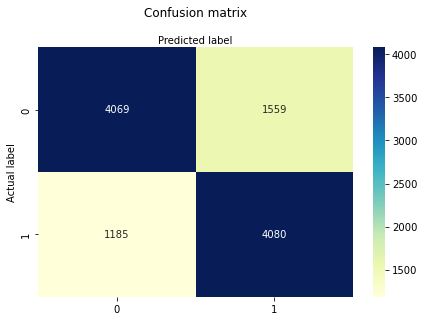

In [94]:
model_confusion_matrix(y_test,log_predictions)

## Machines à vecteurs de support (SVM)

**Algorithme supervisé de classification binaire non linéaire**

In [97]:
from sklearn import svm

In [98]:
svmmodel = svm.SVC(kernel='linear')
svmmodel.fit(transformed_X_train,y_train)
svm_predictions = svmmodel.predict(transformed_X_test)

C:\Users\geoffroy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [99]:
model_score(y_test,svm_predictions)

              precision    recall  f1-score   support

           0       0.78      0.69      0.73      5628
           1       0.71      0.80      0.75      5265

    accuracy                           0.74     10893
   macro avg       0.75      0.74      0.74     10893
weighted avg       0.75      0.74      0.74     10893

Accuracy: 0.7419443679427155


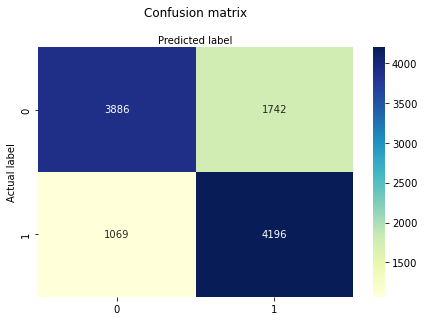

In [100]:
model_confusion_matrix(y_test,svm_predictions)

## Arbres de décision

**Algorithme supervisé de classification ou régression**

*Modèle purement algorithmique ne nécessitant en théorie quasiment pas de transformation des données - peut traiter des données texte, des valeurs nulles etc...- mais en pratique avec scikit-learn on est contraints à ne travailler que des données encodées et normalisées*

In [103]:
from sklearn.tree import DecisionTreeClassifier

In [109]:
treemodel = DecisionTreeClassifier()
treemodel.fit(transformed_X_train,y_train)
tree_predictions = treemodel.predict(transformed_X_test)

In [110]:
model_score(y_test,tree_predictions)

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      5628
           1       0.72      0.73      0.73      5265

    accuracy                           0.73     10893
   macro avg       0.73      0.73      0.73     10893
weighted avg       0.73      0.73      0.73     10893

Accuracy: 0.7335903791425686


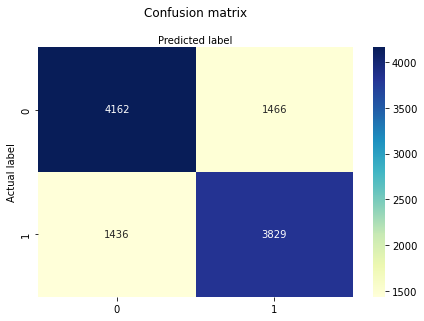

In [111]:
model_confusion_matrix(y_test,tree_predictions)

## Forêts aléatoires

**Combinaison d'arbes de décision, donc possède les mêmes caractéristiques**

In [112]:
from sklearn.ensemble import RandomForestClassifier

In [113]:
forestmodel = RandomForestClassifier(n_estimators=100)
forestmodel.fit(transformed_X_train,y_train)
forest_predictions = forestmodel.predict(transformed_X_test)

C:\Users\geoffroy\AppData\Local\Temp/ipykernel_17036/1618325797.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forestmodel.fit(transformed_X_train,y_train)


In [114]:
model_score(y_test,forest_predictions)

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      5628
           1       0.72      0.76      0.74      5265

    accuracy                           0.74     10893
   macro avg       0.74      0.74      0.74     10893
weighted avg       0.74      0.74      0.74     10893

Accuracy: 0.7375378683558248


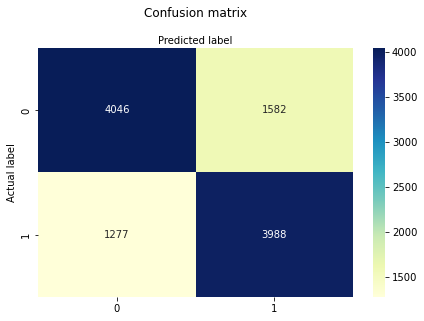

In [115]:
model_confusion_matrix(y_test,forest_predictions)

### Importance des variables

L'implémentation de l'algorithme des forêts aléatoires dans la bibliothèque scikit-learn comprend une méthode intéressante qui permet de déterminer **sur le jeu de données observé (de manière non généralisable donc)** la contribution relative de chaque variable à la variance de la variable cible, autrement dit de classer par ordre de capacité prédictive l'ensemble des variables.

In [116]:
feature_importance = pd.Series(forestmodel.feature_importances_,index=transformed_X_train.columns).sort_values(ascending=False)
feature_importance

remainder__date_pub_std_scaler                     3.323880e-01
remainder__diff_datecreation_datepub_std_scaler    2.575230e-01
onehotencoder__indice_numinv                       6.235491e-02
remainder__acces_indirect                          3.960462e-02
remainder__acq_don                                 2.668705e-02
                                                       ...     
onehotencoder__indice_ND                           1.501932e-05
onehotencoder__indice_05                           1.045334e-05
onehotencoder__indice_bf                           1.027952e-05
onehotencoder__indice_AS                           5.348636e-06
onehotencoder__indice_M2                           6.668254e-07
Length: 162, dtype: float64

In [117]:
transformed_X_train.head()

,onehotencoder__indice_00,onehotencoder__indice_02,onehotencoder__indice_03,onehotencoder__indice_04,onehotencoder__indice_05,onehotencoder__indice_06,onehotencoder__indice_07,onehotencoder__indice_09,onehotencoder__indice_10,onehotencoder__indice_11,...,remainder__bib_LASH,remainder__bib_MEDP,remainder__bib_SCIEN,remainder__bib_SJA,remainder__bib_STAPS,remainder__statut_ex_19,remainder__acces_indirect,remainder__acq_don,remainder__date_pub_std_scaler,remainder__diff_datecreation_datepub_std_scaler
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.074676,-0.174799
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.637569,-0.499671
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.590662,-0.638901
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.614006,1.681609
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.590662,-0.638901
